**Importing Data from .mat files**

In [1]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6


mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
rx_power_tensor[rx_power_tensor==0] = -np.infty
rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts


#print(np.sum((rx_power_tensor==0.0)))
#print(10**(-0.1*np.infty))

print(np.min(rx_power_tensor))

0.0


In [2]:
BW = 400e6
k = 1.38e-23
NF = 10**(0.9)
T = 298

NoisePower = k*BW*NF*T


SNRs = rx_power_tensor/NoisePower

SNRs[SNRs==0.0] = 1e-25 # no paths to -250 dB SNR
print(np.sum((SNRs==1e-25)))


54582


In [3]:

import scipy.io
import numpy as np

num_trajs = 50
n_bs = 4
n_paths = 25
n_time = 3e3
n_features = 6

mat = scipy.io.loadmat('all_azimuth_aoa_tensor_paths.mat')
azimuth_aoa_tensor = mat['azimuth_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aoa_tensor = np.reshape(azimuth_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aoa_tensor = azimuth_aoa_tensor + azimuth_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))



mat = scipy.io.loadmat('all_azimuth_aod_tensor_paths.mat')
azimuth_aod_tensor = mat['azimuth_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
azimuth_aod_tensor = np.reshape(azimuth_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
azimuth_aod_tensor = azimuth_aod_tensor + azimuth_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_zenith_aod_tensor_paths.mat')
zenith_aod_tensor = mat['zenith_aod_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aod_tensor = np.reshape(zenith_aod_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aod_tensor = zenith_aod_tensor + zenith_aod_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))


mat = scipy.io.loadmat('all_zenith_aoa_tensor_paths.mat')
zenith_aoa_tensor = mat['zenith_aoa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
zenith_aoa_tensor = np.reshape(zenith_aoa_tensor,(int(num_trajs*n_time),n_bs,n_paths))
zenith_aoa_tensor = zenith_aoa_tensor + zenith_aoa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

# mat = scipy.io.loadmat('all_rxpower_tensor_paths.mat')
# rx_power_tensor = mat['rx_power_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
# rx_power_tensor = np.reshape(rx_power_tensor,(int(num_trajs*n_time),n_bs,n_paths))
# rx_power_tensor = 10**(0.1*rx_power_tensor) # in Watts

mat = scipy.io.loadmat('all_toa_tensor_paths.mat')
toa_tensor = mat['toa_tensor'] # dimensions are n_traj x n_time x n_bs x n_paths
toa_tensor = np.reshape(toa_tensor,(int(num_trajs*n_time),n_bs,n_paths))*1e3 #in ms
toa_tensor = toa_tensor + toa_tensor/np.sqrt(SNRs)*np.random.normal(0, 1, size=(int(num_trajs*n_time),n_bs,n_paths))

mat = scipy.io.loadmat('all_true_tensor.mat')
true_cord_tensor = mat['true_cord_tensor'] # dimensions are n_traj x n_time x 3
true_cord_tensor = np.reshape(true_cord_tensor,(int(num_trajs*n_time),3))
del mat


In [4]:
print(azimuth_aoa_tensor.shape)

(150000, 4, 25)


**Constructing the input tensor with dimensions n_samples x n_paths x n_bs x n_features**

In [5]:
import math
input_tensor = np.zeros((int(num_trajs*n_time),n_bs,n_paths,n_features))*math.nan

n_samples = int(num_trajs*n_time)


input_tensor[:,:,:,0] = azimuth_aoa_tensor
del azimuth_aoa_tensor

input_tensor[:,:,:,1] = azimuth_aod_tensor
del azimuth_aod_tensor

input_tensor[:,:,:,2] = zenith_aoa_tensor
del zenith_aoa_tensor

input_tensor[:,:,:,3] = zenith_aod_tensor
del zenith_aod_tensor

input_tensor[:,:,:,4] = rx_power_tensor
del rx_power_tensor

input_tensor[:,:,:,5] = toa_tensor
del toa_tensor

print(np.sum(np.isnan(input_tensor))) ## making sure that there are no values left unassigned

0


In [6]:
import tensorflow as tf

from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

input_tensor = np.reshape(input_tensor,(n_samples,int(n_bs*n_paths*n_features)))

**Simple deep neural network approach**

In [7]:
from sklearn import preprocessing


input_tensor = input_tensor 
true_cord_tensor = true_cord_tensor - np.min(true_cord_tensor,axis = 0) ## assuming we know the minimum coordinates
#of UE 
true_cord_tensor = true_cord_tensor*1



model = models.Sequential()
model.add(layers.Dense(256, input_shape=(n_features*n_paths*n_bs,),activation = 'relu'))
model.add(layers.Dense(64,activation = 'relu'))
model.add(layers.Dense(3,activation = 'relu'))
print(model.summary())
opt = tf.keras.optimizers.Adam()

model.compile(loss='mse', optimizer=opt)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               153856    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 195       
Total params: 170,499
Trainable params: 170,499
Non-trainable params: 0
_________________________________________________________________
None


In [8]:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(input_tensor, true_cord_tensor, test_size=0.5)


scaler = preprocessing.StandardScaler()
scaled_df = scaler.fit(X_train)
scaled_df = scaler.transform(X_train)

In [9]:
model.fit(scaled_df, y_train, epochs=300, batch_size=32, verbose = 2)

Epoch 1/300
2344/2344 - 3s - loss: 3813.5730
Epoch 2/300
2344/2344 - 3s - loss: 1158.0377
Epoch 3/300
2344/2344 - 3s - loss: 897.5479
Epoch 4/300
2344/2344 - 3s - loss: 697.4658
Epoch 5/300
2344/2344 - 3s - loss: 617.0628
Epoch 6/300
2344/2344 - 3s - loss: 510.0177
Epoch 7/300
2344/2344 - 3s - loss: 455.4603
Epoch 8/300
2344/2344 - 3s - loss: 558.7109
Epoch 9/300
2344/2344 - 3s - loss: 479.9830
Epoch 10/300
2344/2344 - 3s - loss: 476.6569
Epoch 11/300
2344/2344 - 3s - loss: 420.9806
Epoch 12/300
2344/2344 - 3s - loss: 296.9951
Epoch 13/300
2344/2344 - 3s - loss: 274.3656
Epoch 14/300
2344/2344 - 3s - loss: 319.4566
Epoch 15/300
2344/2344 - 3s - loss: 403.2621
Epoch 16/300
2344/2344 - 3s - loss: 298.6434
Epoch 17/300
2344/2344 - 3s - loss: 366.9524
Epoch 18/300
2344/2344 - 3s - loss: 212.5590
Epoch 19/300
2344/2344 - 3s - loss: 213.5306
Epoch 20/300
2344/2344 - 3s - loss: 417.1064
Epoch 21/300
2344/2344 - 3s - loss: 486.8970
Epoch 22/300
2344/2344 - 3s - loss: 257.1786
Epoch 23/300
2344

Epoch 184/300
2344/2344 - 3s - loss: 59.0901
Epoch 185/300
2344/2344 - 3s - loss: 57.6817
Epoch 186/300
2344/2344 - 3s - loss: 56.4095
Epoch 187/300
2344/2344 - 2s - loss: 93.1077
Epoch 188/300
2344/2344 - 2s - loss: 174.3815
Epoch 189/300
2344/2344 - 2s - loss: 55.9107
Epoch 190/300
2344/2344 - 2s - loss: 54.0146
Epoch 191/300
2344/2344 - 2s - loss: 52.7134
Epoch 192/300
2344/2344 - 2s - loss: 53.5948
Epoch 193/300
2344/2344 - 2s - loss: 53.2620
Epoch 194/300
2344/2344 - 2s - loss: 236.9238
Epoch 195/300
2344/2344 - 2s - loss: 55.5828
Epoch 196/300
2344/2344 - 2s - loss: 52.8658
Epoch 197/300
2344/2344 - 2s - loss: 53.8177
Epoch 198/300
2344/2344 - 3s - loss: 53.5091
Epoch 199/300
2344/2344 - 2s - loss: 53.1841
Epoch 200/300
2344/2344 - 2s - loss: 52.3911
Epoch 201/300
2344/2344 - 2s - loss: 63.7150
Epoch 202/300
2344/2344 - 2s - loss: 51.2596
Epoch 203/300
2344/2344 - 2s - loss: 51.3492
Epoch 204/300
2344/2344 - 2s - loss: 52.3104
Epoch 205/300
2344/2344 - 2s - loss: 53.5283
Epoch 20

In [10]:
pred_vals = model.predict(scaler.transform(input_tensor)) +  np.min(true_cord_tensor)*0

pred_train = model.predict(scaled_df)
pred_test = model.predict(scaler.transform(X_test))

In [11]:
#pred_vals = scaler.inverse_transform(pred_vals)
#pred_train = scaler.inverse_transform(pred_train)
#pred_test = scaler.inverse_transform(pred_test)

In [12]:
norm_error = np.linalg.norm(pred_vals - true_cord_tensor,axis = 1)
norm_error_train = np.linalg.norm(pred_train - y_train,axis = 1)
norm_error_test = np.linalg.norm(pred_test - y_test,axis = 1)
print(norm_error.shape)

(150000,)


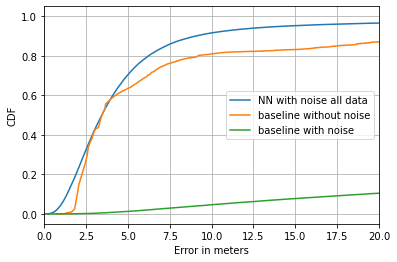

In [13]:
from statsmodels.distributions.empirical_distribution import ECDF

cdf = ECDF(norm_error/1)
plt.plot(cdf.x,cdf.y)
plt.grid()
plt.xlim([0,20])

# cdf = ECDF(norm_error_train/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


# cdf = ECDF(norm_error_test/1)
# plt.plot(cdf.x,cdf.y)
# plt.grid()
# plt.xlim([0,20])


mat = scipy.io.loadmat('baselineerror.mat')
err_data = mat['err_data']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)


mat = scipy.io.loadmat('erorwithnoise.mat')
err_data = mat['eroraray']
err_data = (err_data).flatten()
cdf = ECDF(err_data*1)
plt.plot(cdf.x,cdf.y)

plt.xlabel('Error in meters')
plt.ylabel('CDF')
plt.legend(['NN with noise all data','baseline without noise','baseline with noise'])


In [14]:
print(np.mean(norm_error))

7.34856538029371


In [16]:
cdf = ECDF(norm_error/1)
y = cdf.y
indx = cdf.x[y>0.8]
#print(" {0}":)
print("The 80% percentile error in meters is ", indx[0], end='')

The 80% percentile error in meters is  6.237203888296654